In [105]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import scipy.stats as ss
import statsmodels.api as sm
from mpmath import mp
import math

# Load Data
gene, taxon profile sizes and the similarity scores for eah pair

In [106]:
def load_data():
	
    inFile = open("../../data/Scores_Sizes.txt")

    scores = []
    gene_profile_sizes = []
    taxon_profile_sizes = []

    for line in inFile:
        if "Score" not in line:
            data = line.strip().split("\t")
            score = float(data[6])
            scores.append(score)
            gene_profile_sizes.append(int(data[1]))
            taxon_profile_sizes.append(int(data[4]))
    inFile.close()
    
    return scores, gene_profile_sizes, taxon_profile_sizes

In [107]:
scores, gene_profile_sizes, taxon_profile_sizes = load_data()
gene_taxon_scores = pd.DataFrame(
    {
        'gene': gene_profile_sizes,
        'taxon': taxon_profile_sizes,
        'scores': scores
    })

# Generate average similarity scores

We will compute the average score for each pair (gene_size, taxon_size), in order to manipulate data easily and have clearer view of how the data looks, since multiple pairs genes and taxons with same profile sizes can have same similarity scores.

In [108]:
def generate_avg_scores(gene_taxon_scores):

    if len(gene_taxon_scores) == 0:
        print('missing values for scores/taxon profile sizes/gene profile sizes')
        return

    gene_taxon_scores = gene_taxon_scores.groupby(['taxon','gene'], as_index=False)['scores'].mean() 
    gene_taxon_scores.rename(columns={'scores':'avg_scores'}, inplace=True)    
    print(gene_taxon_scores.head())
    return gene_taxon_scores

In [109]:
gene_taxon_avg_scores = generate_avg_scores(gene_taxon_scores)

   taxon  gene  avg_scores
0      2     2    0.053801
1      2     3    0.109874
2      2     4    0.106818
3      2     5    0.124769
4      2     6    0.138121


# Data Transformation

Log Transformations
We will obtain the log for taxon/gene profile sizes, similarity score. These values will be used later in multiple linear regressions. 

## Log Transformation

Gene Logarithm, Taxon Logarithm, Average scores

In [110]:
geneLog = gene_taxon_avg_scores['gene'].apply(np.log)
taxonLog = gene_taxon_avg_scores['taxon'].apply(np.log)
avg_scoresLog = gene_taxon_avg_scores['avg_scores'].apply(np.log)

geneLog_taxonLog_avg_scoresLog = pd.DataFrame(
    {
        'geneLog': geneLog,
        'taxonLog': taxonLog,
        'avg_scoresLog': avg_scoresLog
    })
print(geneLog_taxonLog_avg_scoresLog.head())

    geneLog  taxonLog  avg_scoresLog
0  0.693147  0.693147      -2.922465
1  1.098612  0.693147      -2.208417
2  1.386294  0.693147      -2.236628
3  1.609438  0.693147      -2.081288
4  1.791759  0.693147      -1.979628


Build a histogram with the avg scores values

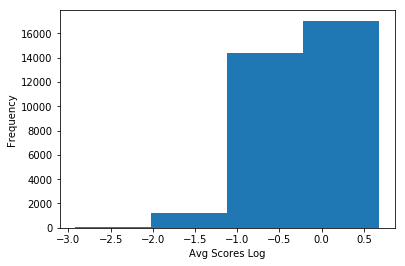

In [111]:
plt.hist(avg_scoresLog, bins=4)
plt.xlabel('Avg Scores Log')
plt.ylabel('Frequency')
plt.show()

Let's see the line of best fit

In [ ]:
z = np.polyfit([geneLog, taxonLog], avg_scoresLog, 1)
p = np.poly1d(z)
intercept = coeffs[-1]
slope = coeffs[-2]
power = coeffs[0] if order == 2 else 0

    minxd = np.min(xd)
    maxxd = np.max(xd)

    xl = np.array([minxd, maxxd])
    yl = power * xl ** 2 + slope * xl + intercept

    #Plot trendline
    plt.plot(xl, yl, c, alpha=alpha)
>>> plt.show()

In [112]:
def compute_std_dev():
    
    std_dev = 0
    mean = avg_scoresLog.mean()
    for score in avg_scoresLog:
        input = score-mean
        std_dev = std_dev + math.pow(input, 2)
    
    std_dev = std_dev/len(avg_scoresLog)
    std_dev = math.sqrt(std_dev)
    return std_dev    

In [113]:
def compute_z_values(const, coeff_taxonLog, coeff_geneLog, std_dev):
            
    z_values = []
    for i in range(len(avg_scoresLog)):
        observed_value = avg_scoresLog[i]
        predicted_value = const + coeff_taxonLog*taxonLog[i] + coeff_geneLog*geneLog[i]
        z_value = (observed_value - predicted_value)/std_dev
        z_values.append(z_value)
        
    return z_values

These are the equation's coefficients obtained when we used WLS multiple linear regression on log gene size, log taxon size, log avg scores.

In [114]:
const = -2.903170
coeff_taxonLog = 0.252263
coeff_geneLog = 0.378430

We will compute p values for all the average scores. In order to do that, we will have to compute first the Z values for all avg scores.

## Computing Z values

In [115]:
std_deviation = compute_std_dev()
z_values = compute_z_values(const, coeff_taxonLog, coeff_geneLog, std_deviation)
for i in range(5):
    print(z_values[i]) 

-1.1464506607414986
0.26158359829002203
-0.08270465606688727
0.09535790522648702
0.1773980045008009


## Computing p values

In [116]:
p_values = []
for z_value in z_values:    
    no = -math.e **(-z_value*math.pi/math.sqrt(6)-mp.euler)
    p_value = 1 - math.exp(no)
    p_values.append(p_value)

for i in range(5):
    print(p_values[i]) 

0.577215664901533
0.913087000525771
0.3306411699353998
0.4643575491075679
0.3915406954979779
0.3605873938399269
